# Nuclear Mass Neural Net

This short tensorflow toy trains a standard neural network to output binding energy based on an input neutron and proton number

In [ ]:
import os

import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import sklearn.linear_model as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report

# R2 metric for tensorflow from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

infile = open(data_path("MassEval2016.dat"),'r')

# Prevent TensorFlow from showing us deprecation warnings
tf.logging.set_verbosity(tf.logging.ERROR)

# Read the experimental data with Pandas
Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11),
              names=('N', 'Z', 'A', 'Element', 'Ebinding'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=39,
              index_col=False)

# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000

# Group the DataFrame by nucleon number, A.
#Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
#Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding.max()])
A = Masses['A']
Z = Masses['Z']
N = Masses['N']
Element = Masses['Element']
Energies = Masses['Ebinding']

## All above comes from another notebook

# Build input array
xx = (Z.as_matrix()[:],N.as_matrix()[:])
xx = np.asarray(xx)
xx=xx.T
yy = Energies

# Get a test set for later
x_train, x_test, y_train, y_test = train_test_split(xx,yy,test_size=0.2,random_state=42)

# Scale input

xs_train = x_train.astype(np.float64)
xs_test = x_test.astype(np.float64)

xs_train[:,0] = (x_train[:,0] - np.average(x_train[:,0])) / np.average(x_train[:,0])
xs_test[:,0] = (x_test[:,0] - np.average(x_test[:,0])) / np.average(x_test[:,0])
xs_train[:,1] = (x_train[:,1] - np.average(x_train[:,1])) / np.average(x_train[:,1])
xs_test[:,1] = (x_test[:,1] - np.average(x_test[:,1])) / np.average(x_test[:,1])

print('Training Features:\n   Shape: {}\n   Type: {}\n'.format(xs_train.shape, xs_train.dtype))
print('Training Targets:\n   Shape: {}\n   Type: {}\n'.format(y_train.shape, y_train.dtype))
print('Test Features:\n   Shape: {}\n   Type: {}\n'.format(xs_test.shape, xs_test.dtype))
print('Test Targets:\n   Shape: {}\n   Type: {}\n'.format(y_test.shape, y_test.dtype))

nodes = 50
activation="relu"
model=tf.keras.Sequential() #Define the model object
model.add(tf.keras.layers.Dense(nodes,input_shape=(2,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,input_shape=(nodes,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,input_shape=(nodes,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,input_shape=(nodes,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(1)) #Add the output layer
model.compile(tf.keras.optimizers.Adam(lr=0.0001),loss=tf.keras.losses.MeanSquaredError(),metrics=[R2]) #Adam optimizer and mean squared error loss
results=model.fit(xs_train,y_train,epochs=5000, batch_size=16, validation_split=0.2,verbose=1)

history = results.history
plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0,1)
plt.show()

# test loss calculation

[test_loss,test_R2]=model.evaluate(xs_test, y_test, verbose=1)

print('Test Loss: {:.04}'.format(test_loss))
print('Test R2: {:.04}'.format(test_R2))

en_out=model.predict(xs_test)

# Shift back for plotting

x_shift=xs_test
x_shift[:,0]=xs_test[:,0]*np.average(x_test[:,0])+np.average(x_test[:,0])
x_shift[:,1]=xs_test[:,1]*np.average(x_test[:,1])+np.average(x_test[:,1])

a_sum=np.sum(x_shift,axis=1)

fig, ax = plt.subplots()
ax.set_xlabel(r'$A = N + Z$')
ax.set_ylabel(r'$E_\mathrm{bind}\,/\mathrm{MeV}$')
ax.plot(Masses['A'], Masses['Ebinding'], 'ro',
            label='Ame2016', alpha=0.7,c='b')
ax.plot(a_sum, en_out,'ro',c='m')
ax.legend()
save_fig("Masses2016")
plt.show()

/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Features:
   Shape: (1997, 2)
   Type: float64

Training Targets:
   Shape: (1997,)
   Type: float64

Test Features:
   Shape: (500, 2)
   Type: float64

Test Targets:
   Shape: (500,)
   Type: float64

Train on 1597 samples, validate on 400 samples
Epoch 1/5000
1597/1597 [==============================] - 2s 2ms/sample - loss: 61.9673 - R2: -349.5199 - val_loss: 58.5748 - val_R2: -303.8964
Epoch 2/5000
1597/1597 [==============================] - 0s 302us/sample - loss: 50.1203 - R2: -273.6432 - val_loss: 38.7200 - val_R2: -214.1431
Epoch 3/5000
1597/1597 [==============================] - 0s 287us/sample - loss: 22.6624 - R2: -120.1408 - val_loss: 9.7923 - val_R2: -52.1532
Epoch 4/5000
1597/1597 [==============================] - 0s 296us/sample - loss: 6.4928 - R2: -34.1163 - val_loss: 5.0284 - val_R2: -21.7878
Epoch 5/5000
1597/1597 [==============================] - 0s 281us/sample - loss: 4.2718 - R2: -17.8579 - val_loss: 3.4792 - val_R2: -14.1756
Epoch 6/5000
1597/1597 

Epoch 58/5000
1597/1597 [==============================] - 0s 282us/sample - loss: 0.1428 - R2: 0.6897 - val_loss: 0.1102 - val_R2: 0.7909
Epoch 59/5000
1597/1597 [==============================] - 0s 286us/sample - loss: 0.1412 - R2: 0.6920 - val_loss: 0.1096 - val_R2: 0.7749
Epoch 60/5000
1597/1597 [==============================] - 0s 281us/sample - loss: 0.1429 - R2: 0.6651 - val_loss: 0.1102 - val_R2: 0.7642
Epoch 61/5000
1597/1597 [==============================] - 0s 287us/sample - loss: 0.1412 - R2: 0.6917 - val_loss: 0.1045 - val_R2: 0.7807
Epoch 62/5000
1597/1597 [==============================] - 0s 304us/sample - loss: 0.1335 - R2: 0.7161 - val_loss: 0.1053 - val_R2: 0.6614
Epoch 63/5000
1597/1597 [==============================] - 0s 282us/sample - loss: 0.1409 - R2: 0.6673 - val_loss: 0.1055 - val_R2: 0.7560
Epoch 64/5000
1597/1597 [==============================] - 0s 268us/sample - loss: 0.1386 - R2: 0.6728 - val_loss: 0.1020 - val_R2: 0.7347
Epoch 65/5000
1597/1597 [==

Epoch 117/5000
1597/1597 [==============================] - 0s 280us/sample - loss: 0.1067 - R2: 0.7667 - val_loss: 0.0634 - val_R2: 0.8893
Epoch 118/5000
1597/1597 [==============================] - 0s 273us/sample - loss: 0.1051 - R2: 0.7702 - val_loss: 0.0647 - val_R2: 0.8746
Epoch 119/5000
1597/1597 [==============================] - 0s 282us/sample - loss: 0.1094 - R2: 0.7751 - val_loss: 0.0687 - val_R2: 0.8563
Epoch 120/5000
1597/1597 [==============================] - 0s 277us/sample - loss: 0.1063 - R2: 0.7610 - val_loss: 0.0626 - val_R2: 0.8643
Epoch 121/5000
1597/1597 [==============================] - 0s 278us/sample - loss: 0.1091 - R2: 0.7349 - val_loss: 0.0611 - val_R2: 0.8500
Epoch 122/5000
1597/1597 [==============================] - 0s 294us/sample - loss: 0.1083 - R2: 0.7169 - val_loss: 0.0613 - val_R2: 0.8087
Epoch 123/5000
1597/1597 [==============================] - 0s 297us/sample - loss: 0.1102 - R2: 0.7610 - val_loss: 0.0616 - val_R2: 0.8442
Epoch 124/5000
1597/

1597/1597 [==============================] - 0s 294us/sample - loss: 0.0951 - R2: 0.7588 - val_loss: 0.0487 - val_R2: 0.8594
Epoch 176/5000
1597/1597 [==============================] - 0s 302us/sample - loss: 0.1005 - R2: 0.7399 - val_loss: 0.0548 - val_R2: 0.8056
Epoch 177/5000
1597/1597 [==============================] - 0s 299us/sample - loss: 0.0996 - R2: 0.7704 - val_loss: 0.0551 - val_R2: 0.8288
Epoch 178/5000
1597/1597 [==============================] - 0s 289us/sample - loss: 0.0963 - R2: 0.7659 - val_loss: 0.0461 - val_R2: 0.8970
Epoch 179/5000
1597/1597 [==============================] - 0s 281us/sample - loss: 0.0929 - R2: 0.7770 - val_loss: 0.0466 - val_R2: 0.8576
Epoch 180/5000
1597/1597 [==============================] - 0s 294us/sample - loss: 0.0979 - R2: 0.7464 - val_loss: 0.0591 - val_R2: 0.7920
Epoch 181/5000
1597/1597 [==============================] - 0s 288us/sample - loss: 0.0963 - R2: 0.7680 - val_loss: 0.0519 - val_R2: 0.9046
Epoch 182/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 285us/sample - loss: 0.0956 - R2: 0.7867 - val_loss: 0.0468 - val_R2: 0.8764
Epoch 234/5000
1597/1597 [==============================] - 0s 282us/sample - loss: 0.0939 - R2: 0.7835 - val_loss: 0.0426 - val_R2: 0.9006
Epoch 235/5000
1597/1597 [==============================] - 0s 298us/sample - loss: 0.0903 - R2: 0.7976 - val_loss: 0.0418 - val_R2: 0.8928
Epoch 236/5000
1597/1597 [==============================] - 0s 299us/sample - loss: 0.0911 - R2: 0.7535 - val_loss: 0.0408 - val_R2: 0.8953
Epoch 237/5000
1597/1597 [==============================] - 0s 291us/sample - loss: 0.0923 - R2: 0.7870 - val_loss: 0.0418 - val_R2: 0.8823
Epoch 238/5000
1597/1597 [==============================] - 0s 289us/sample - loss: 0.0879 - R2: 0.8146 - val_loss: 0.0384 - val_R2: 0.8855
Epoch 239/5000
1597/1597 [==============================] - 0s 288us/sample - loss: 0.0894 - R2: 0.7822 - val_loss: 0.0461 - val_R2: 0.9070
Epoch 240/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 305us/sample - loss: 0.0803 - R2: 0.8085 - val_loss: 0.0374 - val_R2: 0.9093
Epoch 292/5000
1597/1597 [==============================] - 0s 289us/sample - loss: 0.0839 - R2: 0.7948 - val_loss: 0.0396 - val_R2: 0.8891
Epoch 293/5000
1597/1597 [==============================] - 0s 299us/sample - loss: 0.0783 - R2: 0.8461 - val_loss: 0.0322 - val_R2: 0.9230
Epoch 294/5000
1597/1597 [==============================] - 0s 290us/sample - loss: 0.0829 - R2: 0.8347 - val_loss: 0.0404 - val_R2: 0.8784
Epoch 295/5000
1597/1597 [==============================] - 0s 291us/sample - loss: 0.0783 - R2: 0.7942 - val_loss: 0.0447 - val_R2: 0.8691
Epoch 296/5000
1597/1597 [==============================] - 0s 288us/sample - loss: 0.0789 - R2: 0.8374 - val_loss: 0.0354 - val_R2: 0.9099
Epoch 297/5000
1597/1597 [==============================] - 0s 286us/sample - loss: 0.0816 - R2: 0.8360 - val_loss: 0.0324 - val_R2: 0.9390
Epoch 298/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 300us/sample - loss: 0.0675 - R2: 0.8217 - val_loss: 0.0311 - val_R2: 0.9502
Epoch 350/5000
1597/1597 [==============================] - 0s 285us/sample - loss: 0.0654 - R2: 0.8830 - val_loss: 0.0267 - val_R2: 0.9337
Epoch 351/5000
1597/1597 [==============================] - 0s 281us/sample - loss: 0.0664 - R2: 0.8268 - val_loss: 0.0308 - val_R2: 0.9532
Epoch 352/5000
1597/1597 [==============================] - 0s 264us/sample - loss: 0.0662 - R2: 0.8774 - val_loss: 0.0313 - val_R2: 0.9546
Epoch 353/5000
1597/1597 [==============================] - 0s 274us/sample - loss: 0.0759 - R2: 0.8108 - val_loss: 0.0367 - val_R2: 0.9211
Epoch 354/5000
1597/1597 [==============================] - 0s 302us/sample - loss: 0.0691 - R2: 0.8544 - val_loss: 0.0250 - val_R2: 0.9463
Epoch 355/5000
1597/1597 [==============================] - 0s 286us/sample - loss: 0.0725 - R2: 0.8249 - val_loss: 0.0278 - val_R2: 0.9235
Epoch 356/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 293us/sample - loss: 0.0599 - R2: 0.9013 - val_loss: 0.0387 - val_R2: 0.9315
Epoch 408/5000
1597/1597 [==============================] - 0s 275us/sample - loss: 0.0602 - R2: 0.9054 - val_loss: 0.0224 - val_R2: 0.9460
Epoch 409/5000
1597/1597 [==============================] - 0s 265us/sample - loss: 0.0635 - R2: 0.8954 - val_loss: 0.0214 - val_R2: 0.9615
Epoch 410/5000
1597/1597 [==============================] - 0s 275us/sample - loss: 0.0571 - R2: 0.8967 - val_loss: 0.0298 - val_R2: 0.9048
Epoch 411/5000
1597/1597 [==============================] - 0s 291us/sample - loss: 0.0594 - R2: 0.8783 - val_loss: 0.0247 - val_R2: 0.9319
Epoch 412/5000
1597/1597 [==============================] - 0s 294us/sample - loss: 0.0566 - R2: 0.8912 - val_loss: 0.0335 - val_R2: 0.9347
Epoch 413/5000
1597/1597 [==============================] - 0s 304us/sample - loss: 0.0604 - R2: 0.8594 - val_loss: 0.0234 - val_R2: 0.9652
Epoch 414/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 286us/sample - loss: 0.0538 - R2: 0.8994 - val_loss: 0.0202 - val_R2: 0.9468
Epoch 466/5000
1597/1597 [==============================] - 0s 287us/sample - loss: 0.0508 - R2: 0.8663 - val_loss: 0.0190 - val_R2: 0.9621
Epoch 467/5000
1597/1597 [==============================] - 0s 294us/sample - loss: 0.0596 - R2: 0.8617 - val_loss: 0.0223 - val_R2: 0.9700
Epoch 468/5000
1597/1597 [==============================] - 0s 290us/sample - loss: 0.0493 - R2: 0.8871 - val_loss: 0.0248 - val_R2: 0.9282
Epoch 469/5000
1597/1597 [==============================] - 0s 271us/sample - loss: 0.0517 - R2: 0.8939 - val_loss: 0.0182 - val_R2: 0.9781
Epoch 470/5000
1597/1597 [==============================] - 0s 267us/sample - loss: 0.0516 - R2: 0.8929 - val_loss: 0.0174 - val_R2: 0.9674
Epoch 471/5000
1597/1597 [==============================] - 0s 275us/sample - loss: 0.0573 - R2: 0.8902 - val_loss: 0.0211 - val_R2: 0.9441
Epoch 472/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 293us/sample - loss: 0.0470 - R2: 0.9190 - val_loss: 0.0176 - val_R2: 0.9695
Epoch 524/5000
1597/1597 [==============================] - 0s 287us/sample - loss: 0.0467 - R2: 0.8939 - val_loss: 0.0195 - val_R2: 0.9565
Epoch 525/5000
1597/1597 [==============================] - 0s 280us/sample - loss: 0.0445 - R2: 0.9245 - val_loss: 0.0210 - val_R2: 0.9546
Epoch 526/5000
1597/1597 [==============================] - 0s 270us/sample - loss: 0.0438 - R2: 0.8938 - val_loss: 0.0191 - val_R2: 0.9657
Epoch 527/5000
1597/1597 [==============================] - 0s 276us/sample - loss: 0.0450 - R2: 0.8865 - val_loss: 0.0185 - val_R2: 0.9751
Epoch 528/5000
1597/1597 [==============================] - 0s 276us/sample - loss: 0.0400 - R2: 0.9181 - val_loss: 0.0436 - val_R2: 0.9366
Epoch 529/5000
1597/1597 [==============================] - 0s 283us/sample - loss: 0.0519 - R2: 0.8526 - val_loss: 0.0158 - val_R2: 0.9773
Epoch 530/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 288us/sample - loss: 0.0399 - R2: 0.8957 - val_loss: 0.0152 - val_R2: 0.9840
Epoch 582/5000
1597/1597 [==============================] - 0s 287us/sample - loss: 0.0370 - R2: 0.9343 - val_loss: 0.0128 - val_R2: 0.9797
Epoch 583/5000
1597/1597 [==============================] - 0s 269us/sample - loss: 0.0390 - R2: 0.9219 - val_loss: 0.0122 - val_R2: 0.9800
Epoch 584/5000
1597/1597 [==============================] - 0s 272us/sample - loss: 0.0372 - R2: 0.9200 - val_loss: 0.0225 - val_R2: 0.9546
Epoch 585/5000
1597/1597 [==============================] - 0s 274us/sample - loss: 0.0388 - R2: 0.9274 - val_loss: 0.0115 - val_R2: 0.9867
Epoch 586/5000
1597/1597 [==============================] - 0s 271us/sample - loss: 0.0388 - R2: 0.9156 - val_loss: 0.0162 - val_R2: 0.9790
Epoch 587/5000
1597/1597 [==============================] - 0s 292us/sample - loss: 0.0364 - R2: 0.9316 - val_loss: 0.0306 - val_R2: 0.9536
Epoch 588/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 272us/sample - loss: 0.0316 - R2: 0.9091 - val_loss: 0.0437 - val_R2: 0.9598
Epoch 640/5000
1597/1597 [==============================] - 0s 275us/sample - loss: 0.0345 - R2: 0.9143 - val_loss: 0.0132 - val_R2: 0.9700
Epoch 641/5000
1597/1597 [==============================] - 0s 272us/sample - loss: 0.0343 - R2: 0.9085 - val_loss: 0.0197 - val_R2: 0.9814
Epoch 642/5000
1597/1597 [==============================] - 0s 268us/sample - loss: 0.0349 - R2: 0.9111 - val_loss: 0.0094 - val_R2: 0.9842
Epoch 643/5000
1597/1597 [==============================] - 0s 287us/sample - loss: 0.0343 - R2: 0.9405 - val_loss: 0.0180 - val_R2: 0.9435
Epoch 644/5000
1597/1597 [==============================] - 0s 287us/sample - loss: 0.0347 - R2: 0.8772 - val_loss: 0.0254 - val_R2: 0.9739
Epoch 645/5000
1597/1597 [==============================] - 0s 281us/sample - loss: 0.0364 - R2: 0.9097 - val_loss: 0.0105 - val_R2: 0.9877
Epoch 646/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 282us/sample - loss: 0.0330 - R2: 0.9474 - val_loss: 0.0164 - val_R2: 0.9835
Epoch 698/5000
1597/1597 [==============================] - 0s 294us/sample - loss: 0.0309 - R2: 0.9134 - val_loss: 0.0147 - val_R2: 0.9736
Epoch 699/5000
1597/1597 [==============================] - 0s 278us/sample - loss: 0.0300 - R2: 0.9504 - val_loss: 0.0153 - val_R2: 0.9636
Epoch 700/5000
1597/1597 [==============================] - 0s 279us/sample - loss: 0.0302 - R2: 0.9592 - val_loss: 0.0150 - val_R2: 0.9878
Epoch 701/5000
1597/1597 [==============================] - 0s 306us/sample - loss: 0.0275 - R2: 0.9688 - val_loss: 0.0087 - val_R2: 0.9893
Epoch 702/5000
1597/1597 [==============================] - 0s 285us/sample - loss: 0.0317 - R2: 0.9201 - val_loss: 0.0082 - val_R2: 0.9815
Epoch 703/5000
1597/1597 [==============================] - 0s 287us/sample - loss: 0.0353 - R2: 0.9222 - val_loss: 0.0141 - val_R2: 0.9857
Epoch 704/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 292us/sample - loss: 0.0416 - R2: 0.9289 - val_loss: 0.0164 - val_R2: 0.9758
Epoch 756/5000
1597/1597 [==============================] - 0s 288us/sample - loss: 0.0271 - R2: 0.9391 - val_loss: 0.0160 - val_R2: 0.9561
Epoch 757/5000
1597/1597 [==============================] - 0s 293us/sample - loss: 0.0339 - R2: 0.9131 - val_loss: 0.0252 - val_R2: 0.9772
Epoch 758/5000
1597/1597 [==============================] - 0s 279us/sample - loss: 0.0278 - R2: 0.9284 - val_loss: 0.0329 - val_R2: 0.9662
Epoch 759/5000
1597/1597 [==============================] - 0s 290us/sample - loss: 0.0354 - R2: 0.9288 - val_loss: 0.0143 - val_R2: 0.9742
Epoch 760/5000
1597/1597 [==============================] - 0s 285us/sample - loss: 0.0328 - R2: 0.9212 - val_loss: 0.0167 - val_R2: 0.9464
Epoch 761/5000
1597/1597 [==============================] - 0s 281us/sample - loss: 0.0307 - R2: 0.9096 - val_loss: 0.0141 - val_R2: 0.9825
Epoch 762/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 304us/sample - loss: 0.0266 - R2: 0.9398 - val_loss: 0.0212 - val_R2: 0.9787
Epoch 814/5000
1597/1597 [==============================] - 0s 300us/sample - loss: 0.0237 - R2: 0.9613 - val_loss: 0.0077 - val_R2: 0.9806
Epoch 815/5000
1597/1597 [==============================] - 0s 281us/sample - loss: 0.0238 - R2: 0.9656 - val_loss: 0.0198 - val_R2: 0.9776
Epoch 816/5000
1597/1597 [==============================] - 0s 267us/sample - loss: 0.0255 - R2: 0.9578 - val_loss: 0.0066 - val_R2: 0.9857
Epoch 817/5000
1597/1597 [==============================] - 0s 272us/sample - loss: 0.0257 - R2: 0.9631 - val_loss: 0.0154 - val_R2: 0.9787
Epoch 818/5000
1597/1597 [==============================] - 0s 289us/sample - loss: 0.0274 - R2: 0.9311 - val_loss: 0.0204 - val_R2: 0.9438
Epoch 819/5000
1597/1597 [==============================] - 0s 304us/sample - loss: 0.0287 - R2: 0.9274 - val_loss: 0.0133 - val_R2: 0.9695
Epoch 820/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 289us/sample - loss: 0.0249 - R2: 0.9319 - val_loss: 0.0113 - val_R2: 0.9681
Epoch 872/5000
1597/1597 [==============================] - 0s 286us/sample - loss: 0.0269 - R2: 0.9540 - val_loss: 0.0224 - val_R2: 0.9684
Epoch 873/5000
1597/1597 [==============================] - 0s 284us/sample - loss: 0.0304 - R2: 0.9481 - val_loss: 0.0135 - val_R2: 0.9837
Epoch 874/5000
1597/1597 [==============================] - 0s 286us/sample - loss: 0.0329 - R2: 0.8954 - val_loss: 0.0148 - val_R2: 0.9864
Epoch 875/5000
1597/1597 [==============================] - 0s 283us/sample - loss: 0.0281 - R2: 0.9146 - val_loss: 0.0115 - val_R2: 0.9726
Epoch 876/5000
1597/1597 [==============================] - 0s 282us/sample - loss: 0.0253 - R2: 0.9376 - val_loss: 0.0113 - val_R2: 0.9695
Epoch 877/5000
1597/1597 [==============================] - 0s 284us/sample - loss: 0.0232 - R2: 0.9403 - val_loss: 0.0090 - val_R2: 0.9849
Epoch 878/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 275us/sample - loss: 0.0193 - R2: 0.9438 - val_loss: 0.0400 - val_R2: 0.9318
Epoch 930/5000
1597/1597 [==============================] - 0s 276us/sample - loss: 0.0292 - R2: 0.9176 - val_loss: 0.0321 - val_R2: 0.9551
Epoch 931/5000
1597/1597 [==============================] - 0s 298us/sample - loss: 0.0225 - R2: 0.9461 - val_loss: 0.0103 - val_R2: 0.9796
Epoch 932/5000
1597/1597 [==============================] - 1s 345us/sample - loss: 0.0270 - R2: 0.9378 - val_loss: 0.0125 - val_R2: 0.9748
Epoch 933/5000
1597/1597 [==============================] - 0s 286us/sample - loss: 0.0228 - R2: 0.9654 - val_loss: 0.0070 - val_R2: 0.9896
Epoch 934/5000
1597/1597 [==============================] - 0s 292us/sample - loss: 0.0230 - R2: 0.9350 - val_loss: 0.0124 - val_R2: 0.9560
Epoch 935/5000
1597/1597 [==============================] - 0s 290us/sample - loss: 0.0249 - R2: 0.9235 - val_loss: 0.0165 - val_R2: 0.9784
Epoch 936/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 288us/sample - loss: 0.0291 - R2: 0.9252 - val_loss: 0.0156 - val_R2: 0.9454
Epoch 988/5000
1597/1597 [==============================] - 0s 272us/sample - loss: 0.0266 - R2: 0.9179 - val_loss: 0.0407 - val_R2: 0.9246
Epoch 989/5000
1597/1597 [==============================] - 0s 288us/sample - loss: 0.0284 - R2: 0.9065 - val_loss: 0.0130 - val_R2: 0.9800
Epoch 990/5000
1597/1597 [==============================] - 0s 281us/sample - loss: 0.0230 - R2: 0.9366 - val_loss: 0.0116 - val_R2: 0.9895
Epoch 991/5000
1597/1597 [==============================] - 0s 296us/sample - loss: 0.0252 - R2: 0.9506 - val_loss: 0.0135 - val_R2: 0.9805
Epoch 992/5000
1597/1597 [==============================] - 0s 300us/sample - loss: 0.0264 - R2: 0.9270 - val_loss: 0.0101 - val_R2: 0.9707
Epoch 993/5000
1597/1597 [==============================] - 0s 291us/sample - loss: 0.0197 - R2: 0.9512 - val_loss: 0.0067 - val_R2: 0.9887
Epoch 994/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 267us/sample - loss: 0.0222 - R2: 0.9623 - val_loss: 0.0144 - val_R2: 0.9816
Epoch 1046/5000
1597/1597 [==============================] - 0s 270us/sample - loss: 0.0206 - R2: 0.9725 - val_loss: 0.0064 - val_R2: 0.9788
Epoch 1047/5000
1597/1597 [==============================] - 0s 282us/sample - loss: 0.0198 - R2: 0.9321 - val_loss: 0.0074 - val_R2: 0.9775
Epoch 1048/5000
1597/1597 [==============================] - 0s 300us/sample - loss: 0.0230 - R2: 0.9626 - val_loss: 0.0167 - val_R2: 0.9813
Epoch 1049/5000
1597/1597 [==============================] - 0s 282us/sample - loss: 0.0172 - R2: 0.9684 - val_loss: 0.0277 - val_R2: 0.9600
Epoch 1050/5000
1597/1597 [==============================] - 0s 289us/sample - loss: 0.0214 - R2: 0.9553 - val_loss: 0.0087 - val_R2: 0.9914
Epoch 1051/5000
1597/1597 [==============================] - 0s 276us/sample - loss: 0.0172 - R2: 0.9746 - val_loss: 0.0062 - val_R2: 0.9846
Epoch 1052/5000
1597/1597 [==

1597/1597 [==============================] - 0s 278us/sample - loss: 0.0210 - R2: 0.9540 - val_loss: 0.0650 - val_R2: 0.8719
Epoch 1104/5000
1597/1597 [==============================] - 0s 297us/sample - loss: 0.0338 - R2: 0.9336 - val_loss: 0.0064 - val_R2: 0.9860
Epoch 1105/5000
1597/1597 [==============================] - 0s 289us/sample - loss: 0.0299 - R2: 0.9363 - val_loss: 0.0089 - val_R2: 0.9721
Epoch 1106/5000
1597/1597 [==============================] - 0s 291us/sample - loss: 0.0243 - R2: 0.9437 - val_loss: 0.0131 - val_R2: 0.9889
Epoch 1107/5000
1597/1597 [==============================] - 0s 280us/sample - loss: 0.0255 - R2: 0.9441 - val_loss: 0.0096 - val_R2: 0.9893
Epoch 1108/5000
1597/1597 [==============================] - 0s 287us/sample - loss: 0.0276 - R2: 0.9357 - val_loss: 0.0128 - val_R2: 0.9689
Epoch 1109/5000
1597/1597 [==============================] - 0s 296us/sample - loss: 0.0204 - R2: 0.9474 - val_loss: 0.0110 - val_R2: 0.9728
Epoch 1110/5000
1597/1597 [==

1597/1597 [==============================] - 0s 284us/sample - loss: 0.0198 - R2: 0.9524 - val_loss: 0.0055 - val_R2: 0.9876
Epoch 1162/5000
1597/1597 [==============================] - 0s 275us/sample - loss: 0.0249 - R2: 0.9482 - val_loss: 0.0423 - val_R2: 0.9452
Epoch 1163/5000
1597/1597 [==============================] - 0s 279us/sample - loss: 0.0310 - R2: 0.9441 - val_loss: 0.0264 - val_R2: 0.9665
Epoch 1164/5000
1597/1597 [==============================] - 0s 270us/sample - loss: 0.0258 - R2: 0.9321 - val_loss: 0.0129 - val_R2: 0.9697
Epoch 1165/5000
1597/1597 [==============================] - 0s 279us/sample - loss: 0.0224 - R2: 0.9429 - val_loss: 0.0058 - val_R2: 0.9866
Epoch 1166/5000
1597/1597 [==============================] - 0s 282us/sample - loss: 0.0226 - R2: 0.9531 - val_loss: 0.0143 - val_R2: 0.9850
Epoch 1167/5000
1597/1597 [==============================] - 0s 278us/sample - loss: 0.0200 - R2: 0.9487 - val_loss: 0.0092 - val_R2: 0.9726
Epoch 1168/5000
1597/1597 [==

1597/1597 [==============================] - 0s 269us/sample - loss: 0.0312 - R2: 0.9275 - val_loss: 0.0072 - val_R2: 0.9884
Epoch 1220/5000
1597/1597 [==============================] - 0s 271us/sample - loss: 0.0240 - R2: 0.9520 - val_loss: 0.0057 - val_R2: 0.9829
Epoch 1221/5000
1597/1597 [==============================] - 0s 286us/sample - loss: 0.0169 - R2: 0.9435 - val_loss: 0.0050 - val_R2: 0.9846
Epoch 1222/5000
1597/1597 [==============================] - 0s 288us/sample - loss: 0.0353 - R2: 0.9113 - val_loss: 0.0291 - val_R2: 0.8802
Epoch 1223/5000
1597/1597 [==============================] - 0s 264us/sample - loss: 0.0217 - R2: 0.9456 - val_loss: 0.0168 - val_R2: 0.9754
Epoch 1224/5000
1597/1597 [==============================] - 0s 269us/sample - loss: 0.0263 - R2: 0.9505 - val_loss: 0.0111 - val_R2: 0.9866
Epoch 1225/5000
1597/1597 [==============================] - 0s 292us/sample - loss: 0.0228 - R2: 0.9525 - val_loss: 0.0086 - val_R2: 0.9908
Epoch 1226/5000
1597/1597 [==

1597/1597 [==============================] - 0s 274us/sample - loss: 0.0166 - R2: 0.9400 - val_loss: 0.0234 - val_R2: 0.9564
Epoch 1278/5000
1597/1597 [==============================] - 0s 289us/sample - loss: 0.0168 - R2: 0.9725 - val_loss: 0.0116 - val_R2: 0.9884
Epoch 1279/5000
1597/1597 [==============================] - 0s 281us/sample - loss: 0.0225 - R2: 0.9372 - val_loss: 0.0219 - val_R2: 0.9284
Epoch 1280/5000
1597/1597 [==============================] - 0s 292us/sample - loss: 0.0250 - R2: 0.9240 - val_loss: 0.0415 - val_R2: 0.9603
Epoch 1281/5000
1597/1597 [==============================] - 0s 282us/sample - loss: 0.0243 - R2: 0.9421 - val_loss: 0.0129 - val_R2: 0.9689
Epoch 1282/5000
1597/1597 [==============================] - 0s 294us/sample - loss: 0.0185 - R2: 0.9321 - val_loss: 0.0516 - val_R2: 0.9358
Epoch 1283/5000
1597/1597 [==============================] - 0s 299us/sample - loss: 0.0230 - R2: 0.9461 - val_loss: 0.0080 - val_R2: 0.9899
Epoch 1284/5000
1597/1597 [==

1597/1597 [==============================] - 0s 278us/sample - loss: 0.0187 - R2: 0.9525 - val_loss: 0.0098 - val_R2: 0.9834
Epoch 1336/5000
1597/1597 [==============================] - 0s 283us/sample - loss: 0.0255 - R2: 0.9194 - val_loss: 0.0234 - val_R2: 0.9230
Epoch 1337/5000
1597/1597 [==============================] - 0s 283us/sample - loss: 0.0235 - R2: 0.9534 - val_loss: 0.0207 - val_R2: 0.9158
Epoch 1338/5000
1597/1597 [==============================] - 0s 284us/sample - loss: 0.0217 - R2: 0.9563 - val_loss: 0.0191 - val_R2: 0.9775
Epoch 1339/5000
1597/1597 [==============================] - 0s 262us/sample - loss: 0.0190 - R2: 0.9169 - val_loss: 0.0644 - val_R2: 0.9290
Epoch 1340/5000
1597/1597 [==============================] - 0s 278us/sample - loss: 0.0200 - R2: 0.9391 - val_loss: 0.0076 - val_R2: 0.9784
Epoch 1341/5000
1597/1597 [==============================] - 0s 279us/sample - loss: 0.0179 - R2: 0.9584 - val_loss: 0.0302 - val_R2: 0.9675
Epoch 1342/5000
1597/1597 [==

1597/1597 [==============================] - 0s 283us/sample - loss: 0.0274 - R2: 0.9342 - val_loss: 0.0157 - val_R2: 0.9833
Epoch 1394/5000
1597/1597 [==============================] - 0s 296us/sample - loss: 0.0203 - R2: 0.9511 - val_loss: 0.0067 - val_R2: 0.9864
Epoch 1395/5000
1597/1597 [==============================] - 0s 293us/sample - loss: 0.0224 - R2: 0.9348 - val_loss: 0.0123 - val_R2: 0.9850
Epoch 1396/5000
1597/1597 [==============================] - 0s 297us/sample - loss: 0.0158 - R2: 0.9551 - val_loss: 0.0207 - val_R2: 0.9792
Epoch 1397/5000
1597/1597 [==============================] - 0s 286us/sample - loss: 0.0183 - R2: 0.9697 - val_loss: 0.0092 - val_R2: 0.9677
Epoch 1398/5000
1597/1597 [==============================] - 0s 287us/sample - loss: 0.0157 - R2: 0.9673 - val_loss: 0.0047 - val_R2: 0.9834
Epoch 1399/5000
1597/1597 [==============================] - 0s 288us/sample - loss: 0.0218 - R2: 0.9478 - val_loss: 0.0131 - val_R2: 0.9798
Epoch 1400/5000
1597/1597 [==

1597/1597 [==============================] - 0s 277us/sample - loss: 0.0212 - R2: 0.9579 - val_loss: 0.0403 - val_R2: 0.9240
Epoch 1452/5000
1597/1597 [==============================] - 0s 281us/sample - loss: 0.0142 - R2: 0.9559 - val_loss: 0.0159 - val_R2: 0.9839
Epoch 1453/5000
1597/1597 [==============================] - 0s 285us/sample - loss: 0.0217 - R2: 0.9132 - val_loss: 0.0197 - val_R2: 0.9744
Epoch 1454/5000
1597/1597 [==============================] - 0s 273us/sample - loss: 0.0154 - R2: 0.9625 - val_loss: 0.0538 - val_R2: 0.9026
Epoch 1455/5000
1597/1597 [==============================] - 0s 293us/sample - loss: 0.0194 - R2: 0.9638 - val_loss: 0.0041 - val_R2: 0.9868
Epoch 1456/5000
1597/1597 [==============================] - 0s 288us/sample - loss: 0.0272 - R2: 0.9273 - val_loss: 0.0106 - val_R2: 0.9788
Epoch 1457/5000
1597/1597 [==============================] - 0s 286us/sample - loss: 0.0157 - R2: 0.9390 - val_loss: 0.0648 - val_R2: 0.8818
Epoch 1458/5000
1597/1597 [==

1597/1597 [==============================] - 0s 285us/sample - loss: 0.0154 - R2: 0.9611 - val_loss: 0.0109 - val_R2: 0.9808
Epoch 1510/5000
1597/1597 [==============================] - 0s 291us/sample - loss: 0.0153 - R2: 0.9618 - val_loss: 0.0037 - val_R2: 0.9857
Epoch 1511/5000
1597/1597 [==============================] - 0s 286us/sample - loss: 0.0137 - R2: 0.9630 - val_loss: 0.0153 - val_R2: 0.9826
Epoch 1512/5000
1597/1597 [==============================] - 0s 281us/sample - loss: 0.0147 - R2: 0.9641 - val_loss: 0.0062 - val_R2: 0.9910
Epoch 1513/5000
1597/1597 [==============================] - 0s 287us/sample - loss: 0.0163 - R2: 0.9519 - val_loss: 0.0038 - val_R2: 0.9882
Epoch 1514/5000
1597/1597 [==============================] - 0s 298us/sample - loss: 0.0266 - R2: 0.9338 - val_loss: 0.0044 - val_R2: 0.9835
Epoch 1515/5000
1597/1597 [==============================] - 0s 273us/sample - loss: 0.0186 - R2: 0.9570 - val_loss: 0.0068 - val_R2: 0.9900
Epoch 1516/5000
1597/1597 [==

1597/1597 [==============================] - 0s 282us/sample - loss: 0.0130 - R2: 0.9732 - val_loss: 0.0153 - val_R2: 0.9592
Epoch 1568/5000
1597/1597 [==============================] - 0s 270us/sample - loss: 0.0186 - R2: 0.9493 - val_loss: 0.0180 - val_R2: 0.9663
Epoch 1569/5000
1597/1597 [==============================] - 0s 298us/sample - loss: 0.0102 - R2: 0.9747 - val_loss: 0.0103 - val_R2: 0.9819
Epoch 1570/5000
1597/1597 [==============================] - 0s 300us/sample - loss: 0.0370 - R2: 0.9094 - val_loss: 0.0036 - val_R2: 0.9865
Epoch 1571/5000
1597/1597 [==============================] - 0s 303us/sample - loss: 0.0169 - R2: 0.9743 - val_loss: 0.0131 - val_R2: 0.9373
Epoch 1572/5000
1597/1597 [==============================] - 0s 297us/sample - loss: 0.0147 - R2: 0.9719 - val_loss: 0.0655 - val_R2: 0.9246
Epoch 1573/5000
1597/1597 [==============================] - 0s 307us/sample - loss: 0.0428 - R2: 0.9107 - val_loss: 0.0216 - val_R2: 0.9056
Epoch 1574/5000
1597/1597 [==

1597/1597 [==============================] - 0s 288us/sample - loss: 0.0153 - R2: 0.9584 - val_loss: 0.0049 - val_R2: 0.9876
Epoch 1626/5000
1597/1597 [==============================] - 0s 279us/sample - loss: 0.0105 - R2: 0.9854 - val_loss: 0.0069 - val_R2: 0.9800
Epoch 1627/5000
1597/1597 [==============================] - 0s 294us/sample - loss: 0.0155 - R2: 0.9721 - val_loss: 0.0163 - val_R2: 0.9367
Epoch 1628/5000
1597/1597 [==============================] - 1s 320us/sample - loss: 0.0164 - R2: 0.9429 - val_loss: 0.0138 - val_R2: 0.9863
Epoch 1629/5000
1597/1597 [==============================] - 1s 333us/sample - loss: 0.0129 - R2: 0.9660 - val_loss: 0.0664 - val_R2: 0.9296
Epoch 1630/5000
1597/1597 [==============================] - 0s 307us/sample - loss: 0.0197 - R2: 0.9546 - val_loss: 0.0164 - val_R2: 0.9822
Epoch 1631/5000
1597/1597 [==============================] - 1s 320us/sample - loss: 0.0178 - R2: 0.9438 - val_loss: 0.0052 - val_R2: 0.9838
Epoch 1632/5000
1597/1597 [==

1597/1597 [==============================] - 0s 302us/sample - loss: 0.0182 - R2: 0.9670 - val_loss: 0.0243 - val_R2: 0.9712
Epoch 1684/5000
1597/1597 [==============================] - 0s 292us/sample - loss: 0.0327 - R2: 0.9296 - val_loss: 0.0281 - val_R2: 0.9590
Epoch 1685/5000
1597/1597 [==============================] - 0s 281us/sample - loss: 0.0218 - R2: 0.9465 - val_loss: 0.0127 - val_R2: 0.9866
Epoch 1686/5000
1597/1597 [==============================] - 0s 281us/sample - loss: 0.0144 - R2: 0.9595 - val_loss: 0.0127 - val_R2: 0.9796
Epoch 1687/5000
1597/1597 [==============================] - 0s 272us/sample - loss: 0.0119 - R2: 0.9772 - val_loss: 0.0045 - val_R2: 0.9859
Epoch 1688/5000
1597/1597 [==============================] - 0s 281us/sample - loss: 0.0084 - R2: 0.9831 - val_loss: 0.0169 - val_R2: 0.9832
Epoch 1689/5000
1597/1597 [==============================] - 0s 278us/sample - loss: 0.0100 - R2: 0.9682 - val_loss: 0.0225 - val_R2: 0.9737
Epoch 1690/5000
1597/1597 [==

1597/1597 [==============================] - 0s 272us/sample - loss: 0.0120 - R2: 0.9614 - val_loss: 0.0431 - val_R2: 0.9539
Epoch 1742/5000
1597/1597 [==============================] - 0s 271us/sample - loss: 0.0174 - R2: 0.9511 - val_loss: 0.0054 - val_R2: 0.9782
Epoch 1743/5000
1597/1597 [==============================] - 0s 289us/sample - loss: 0.0482 - R2: 0.9113 - val_loss: 0.0068 - val_R2: 0.9770
Epoch 1744/5000
1597/1597 [==============================] - 0s 304us/sample - loss: 0.0239 - R2: 0.9311 - val_loss: 0.0157 - val_R2: 0.9485
Epoch 1745/5000
1597/1597 [==============================] - 0s 291us/sample - loss: 0.0144 - R2: 0.9431 - val_loss: 0.0115 - val_R2: 0.9851
Epoch 1746/5000
1597/1597 [==============================] - 0s 287us/sample - loss: 0.0219 - R2: 0.9445 - val_loss: 0.0125 - val_R2: 0.9835
Epoch 1747/5000
1597/1597 [==============================] - 0s 304us/sample - loss: 0.0119 - R2: 0.9784 - val_loss: 0.0092 - val_R2: 0.9831
Epoch 1748/5000
1597/1597 [==

1597/1597 [==============================] - 0s 306us/sample - loss: 0.0134 - R2: 0.9531 - val_loss: 0.0226 - val_R2: 0.9819
Epoch 1800/5000
1597/1597 [==============================] - 0s 279us/sample - loss: 0.0196 - R2: 0.9507 - val_loss: 0.0053 - val_R2: 0.9781
Epoch 1801/5000
1597/1597 [==============================] - 0s 286us/sample - loss: 0.0109 - R2: 0.9810 - val_loss: 0.0075 - val_R2: 0.9920
Epoch 1802/5000
1597/1597 [==============================] - 0s 301us/sample - loss: 0.0082 - R2: 0.9831 - val_loss: 0.0084 - val_R2: 0.9875
Epoch 1803/5000
1597/1597 [==============================] - 0s 284us/sample - loss: 0.0089 - R2: 0.9826 - val_loss: 0.0048 - val_R2: 0.9853
Epoch 1804/5000
1597/1597 [==============================] - 0s 289us/sample - loss: 0.0148 - R2: 0.9694 - val_loss: 0.0167 - val_R2: 0.9819
Epoch 1805/5000
1597/1597 [==============================] - 0s 283us/sample - loss: 0.0113 - R2: 0.9782 - val_loss: 0.0061 - val_R2: 0.9919
Epoch 1806/5000
1597/1597 [==

1597/1597 [==============================] - 0s 285us/sample - loss: 0.0123 - R2: 0.9686 - val_loss: 0.0194 - val_R2: 0.9709
Epoch 1858/5000
1597/1597 [==============================] - 0s 272us/sample - loss: 0.0131 - R2: 0.9721 - val_loss: 0.0196 - val_R2: 0.9852
Epoch 1859/5000
1597/1597 [==============================] - 0s 272us/sample - loss: 0.0100 - R2: 0.9756 - val_loss: 0.0269 - val_R2: 0.9740
Epoch 1860/5000
1597/1597 [==============================] - 0s 303us/sample - loss: 0.0120 - R2: 0.9759 - val_loss: 0.0138 - val_R2: 0.9670
Epoch 1861/5000
1597/1597 [==============================] - 0s 298us/sample - loss: 0.0100 - R2: 0.9782 - val_loss: 0.0021 - val_R2: 0.9920
Epoch 1862/5000
1597/1597 [==============================] - 1s 314us/sample - loss: 0.0108 - R2: 0.9672 - val_loss: 0.0244 - val_R2: 0.9747
Epoch 1863/5000
1597/1597 [==============================] - 0s 306us/sample - loss: 0.0152 - R2: 0.9714 - val_loss: 0.0090 - val_R2: 0.9858
Epoch 1864/5000
1597/1597 [==

1597/1597 [==============================] - 0s 275us/sample - loss: 0.0119 - R2: 0.9684 - val_loss: 0.0068 - val_R2: 0.9767
Epoch 1916/5000
1597/1597 [==============================] - 0s 305us/sample - loss: 0.0108 - R2: 0.9701 - val_loss: 0.0092 - val_R2: 0.9649
Epoch 1917/5000
1597/1597 [==============================] - 0s 300us/sample - loss: 0.0186 - R2: 0.9602 - val_loss: 0.0049 - val_R2: 0.9781
Epoch 1918/5000
1597/1597 [==============================] - 0s 299us/sample - loss: 0.0282 - R2: 0.9489 - val_loss: 0.0132 - val_R2: 0.9868
Epoch 1919/5000
1597/1597 [==============================] - 0s 281us/sample - loss: 0.0219 - R2: 0.9131 - val_loss: 0.0386 - val_R2: 0.9633
Epoch 1920/5000
1597/1597 [==============================] - 0s 267us/sample - loss: 0.0113 - R2: 0.9799 - val_loss: 0.0026 - val_R2: 0.9941
Epoch 1921/5000
1597/1597 [==============================] - 0s 284us/sample - loss: 0.0139 - R2: 0.9716 - val_loss: 0.0131 - val_R2: 0.9822
Epoch 1922/5000
1597/1597 [==

1597/1597 [==============================] - 0s 266us/sample - loss: 0.0237 - R2: 0.9576 - val_loss: 0.0316 - val_R2: 0.9763
Epoch 1974/5000
1597/1597 [==============================] - 0s 272us/sample - loss: 0.0231 - R2: 0.9274 - val_loss: 0.0079 - val_R2: 0.9918
Epoch 1975/5000
1597/1597 [==============================] - 0s 267us/sample - loss: 0.0112 - R2: 0.9657 - val_loss: 0.0114 - val_R2: 0.9800
Epoch 1976/5000
1597/1597 [==============================] - 0s 266us/sample - loss: 0.0097 - R2: 0.9757 - val_loss: 0.0214 - val_R2: 0.9764
Epoch 1977/5000
1597/1597 [==============================] - 0s 285us/sample - loss: 0.0082 - R2: 0.9705 - val_loss: 0.0047 - val_R2: 0.9890
Epoch 1978/5000
1597/1597 [==============================] - 0s 293us/sample - loss: 0.0084 - R2: 0.9717 - val_loss: 0.0147 - val_R2: 0.9847
Epoch 1979/5000
1597/1597 [==============================] - 0s 295us/sample - loss: 0.0091 - R2: 0.9737 - val_loss: 0.0100 - val_R2: 0.9882
Epoch 1980/5000
1597/1597 [==

1597/1597 [==============================] - 0s 306us/sample - loss: 0.0129 - R2: 0.9470 - val_loss: 0.0690 - val_R2: 0.9268
Epoch 2032/5000
1597/1597 [==============================] - 0s 288us/sample - loss: 0.0285 - R2: 0.9443 - val_loss: 0.0088 - val_R2: 0.9700
Epoch 2033/5000
1597/1597 [==============================] - 0s 288us/sample - loss: 0.0154 - R2: 0.9565 - val_loss: 0.0067 - val_R2: 0.9877
Epoch 2034/5000
1597/1597 [==============================] - 0s 286us/sample - loss: 0.0077 - R2: 0.9738 - val_loss: 0.0058 - val_R2: 0.9692
Epoch 2035/5000
1597/1597 [==============================] - 0s 308us/sample - loss: 0.0105 - R2: 0.9727 - val_loss: 0.0172 - val_R2: 0.9749
Epoch 2036/5000
1597/1597 [==============================] - 0s 290us/sample - loss: 0.0160 - R2: 0.9690 - val_loss: 0.0072 - val_R2: 0.9886
Epoch 2037/5000
1597/1597 [==============================] - 0s 286us/sample - loss: 0.0134 - R2: 0.9653 - val_loss: 0.0065 - val_R2: 0.9899
Epoch 2038/5000
1597/1597 [==

1597/1597 [==============================] - 0s 286us/sample - loss: 0.0180 - R2: 0.9425 - val_loss: 0.0049 - val_R2: 0.9772
Epoch 2090/5000
1597/1597 [==============================] - 0s 277us/sample - loss: 0.0102 - R2: 0.9774 - val_loss: 0.0442 - val_R2: 0.9670
Epoch 2091/5000
1597/1597 [==============================] - 0s 297us/sample - loss: 0.0284 - R2: 0.9303 - val_loss: 0.0307 - val_R2: 0.9775
Epoch 2092/5000
1597/1597 [==============================] - 0s 289us/sample - loss: 0.0092 - R2: 0.9695 - val_loss: 0.0186 - val_R2: 0.9810
Epoch 2093/5000
1597/1597 [==============================] - 0s 273us/sample - loss: 0.0106 - R2: 0.9678 - val_loss: 0.0042 - val_R2: 0.9837
Epoch 2094/5000
1597/1597 [==============================] - 0s 288us/sample - loss: 0.0075 - R2: 0.9859 - val_loss: 0.0060 - val_R2: 0.9856
Epoch 2095/5000
1597/1597 [==============================] - 0s 309us/sample - loss: 0.0100 - R2: 0.9751 - val_loss: 0.0109 - val_R2: 0.9901
Epoch 2096/5000
1597/1597 [==

1597/1597 [==============================] - 0s 291us/sample - loss: 0.0069 - R2: 0.9787 - val_loss: 0.0089 - val_R2: 0.9884
Epoch 2148/5000
1597/1597 [==============================] - 0s 302us/sample - loss: 0.0091 - R2: 0.9692 - val_loss: 0.0224 - val_R2: 0.9741
Epoch 2149/5000
1597/1597 [==============================] - 0s 292us/sample - loss: 0.0209 - R2: 0.9561 - val_loss: 0.0052 - val_R2: 0.9904
Epoch 2150/5000
1597/1597 [==============================] - 0s 296us/sample - loss: 0.0081 - R2: 0.9760 - val_loss: 0.0092 - val_R2: 0.9836
Epoch 2151/5000
1597/1597 [==============================] - 0s 302us/sample - loss: 0.0132 - R2: 0.9684 - val_loss: 0.0072 - val_R2: 0.9812
Epoch 2152/5000
1597/1597 [==============================] - 0s 280us/sample - loss: 0.0147 - R2: 0.9446 - val_loss: 0.0032 - val_R2: 0.9857
Epoch 2153/5000
1597/1597 [==============================] - 0s 282us/sample - loss: 0.0119 - R2: 0.9634 - val_loss: 0.0082 - val_R2: 0.9810
Epoch 2154/5000
1597/1597 [==

1597/1597 [==============================] - 0s 276us/sample - loss: 0.0080 - R2: 0.9768 - val_loss: 0.0036 - val_R2: 0.9930
Epoch 2206/5000
1597/1597 [==============================] - 0s 273us/sample - loss: 0.0076 - R2: 0.9714 - val_loss: 0.0226 - val_R2: 0.9781
Epoch 2207/5000
1597/1597 [==============================] - 0s 274us/sample - loss: 0.0116 - R2: 0.9771 - val_loss: 0.0082 - val_R2: 0.9665
Epoch 2208/5000
1597/1597 [==============================] - 0s 269us/sample - loss: 0.0621 - R2: 0.9003 - val_loss: 0.0865 - val_R2: 0.9293
Epoch 2209/5000
1597/1597 [==============================] - 0s 286us/sample - loss: 0.0239 - R2: 0.9592 - val_loss: 0.0077 - val_R2: 0.9901
Epoch 2210/5000
1597/1597 [==============================] - 0s 288us/sample - loss: 0.0084 - R2: 0.9761 - val_loss: 0.0032 - val_R2: 0.9877
Epoch 2211/5000
1597/1597 [==============================] - 0s 307us/sample - loss: 0.0068 - R2: 0.9774 - val_loss: 0.0029 - val_R2: 0.9893
Epoch 2212/5000
1597/1597 [==

1597/1597 [==============================] - 0s 286us/sample - loss: 0.0301 - R2: 0.9294 - val_loss: 0.0384 - val_R2: 0.9292
Epoch 2264/5000
1597/1597 [==============================] - 0s 272us/sample - loss: 0.0160 - R2: 0.9603 - val_loss: 0.0025 - val_R2: 0.9899
Epoch 2265/5000
1597/1597 [==============================] - 0s 265us/sample - loss: 0.0192 - R2: 0.9546 - val_loss: 0.0055 - val_R2: 0.9915
Epoch 2266/5000
1597/1597 [==============================] - 0s 284us/sample - loss: 0.0099 - R2: 0.9696 - val_loss: 0.0128 - val_R2: 0.9847
Epoch 2267/5000
1597/1597 [==============================] - 0s 291us/sample - loss: 0.0242 - R2: 0.9603 - val_loss: 0.0122 - val_R2: 0.9618
Epoch 2268/5000
1597/1597 [==============================] - 0s 296us/sample - loss: 0.0078 - R2: 0.9731 - val_loss: 0.0190 - val_R2: 0.9788
Epoch 2269/5000
1597/1597 [==============================] - 0s 285us/sample - loss: 0.0092 - R2: 0.9806 - val_loss: 0.0333 - val_R2: 0.9727
Epoch 2270/5000
1597/1597 [==

1597/1597 [==============================] - 0s 300us/sample - loss: 0.0151 - R2: 0.9646 - val_loss: 0.0096 - val_R2: 0.9910
Epoch 2322/5000
1597/1597 [==============================] - 0s 301us/sample - loss: 0.0067 - R2: 0.9789 - val_loss: 0.0173 - val_R2: 0.9729
Epoch 2323/5000
1597/1597 [==============================] - 0s 293us/sample - loss: 0.0103 - R2: 0.9762 - val_loss: 0.0093 - val_R2: 0.9899
Epoch 2324/5000
1597/1597 [==============================] - 0s 292us/sample - loss: 0.0090 - R2: 0.9803 - val_loss: 0.0032 - val_R2: 0.9926
Epoch 2325/5000
1597/1597 [==============================] - 0s 286us/sample - loss: 0.0053 - R2: 0.9816 - val_loss: 0.0027 - val_R2: 0.9922
Epoch 2326/5000
1597/1597 [==============================] - 0s 288us/sample - loss: 0.0094 - R2: 0.9738 - val_loss: 0.0055 - val_R2: 0.9832
Epoch 2327/5000
1597/1597 [==============================] - 0s 291us/sample - loss: 0.0138 - R2: 0.9480 - val_loss: 0.0067 - val_R2: 0.9813
Epoch 2328/5000
1597/1597 [==

1597/1597 [==============================] - 0s 289us/sample - loss: 0.0306 - R2: 0.9134 - val_loss: 0.0239 - val_R2: 0.9798
Epoch 2380/5000
1597/1597 [==============================] - 0s 268us/sample - loss: 0.0216 - R2: 0.9515 - val_loss: 0.0079 - val_R2: 0.9816
Epoch 2381/5000
1597/1597 [==============================] - 0s 299us/sample - loss: 0.0121 - R2: 0.9742 - val_loss: 0.0044 - val_R2: 0.9891
Epoch 2382/5000
1597/1597 [==============================] - 0s 292us/sample - loss: 0.0104 - R2: 0.9732 - val_loss: 0.0053 - val_R2: 0.9850
Epoch 2383/5000
1597/1597 [==============================] - 0s 303us/sample - loss: 0.0362 - R2: 0.9138 - val_loss: 0.0025 - val_R2: 0.9917
Epoch 2384/5000
1597/1597 [==============================] - 0s 286us/sample - loss: 0.0091 - R2: 0.9822 - val_loss: 0.0143 - val_R2: 0.9850
Epoch 2385/5000
1597/1597 [==============================] - 0s 285us/sample - loss: 0.0086 - R2: 0.9841 - val_loss: 0.0120 - val_R2: 0.9822
Epoch 2386/5000
1597/1597 [==

1597/1597 [==============================] - 0s 289us/sample - loss: 0.0158 - R2: 0.9619 - val_loss: 0.0182 - val_R2: 0.9793
Epoch 2438/5000
1597/1597 [==============================] - 0s 301us/sample - loss: 0.0069 - R2: 0.9788 - val_loss: 0.0072 - val_R2: 0.9917
Epoch 2439/5000
1597/1597 [==============================] - 0s 291us/sample - loss: 0.0134 - R2: 0.9772 - val_loss: 0.0235 - val_R2: 0.9455
Epoch 2440/5000
1597/1597 [==============================] - 0s 301us/sample - loss: 0.0153 - R2: 0.9655 - val_loss: 0.0237 - val_R2: 0.9659
Epoch 2441/5000
1597/1597 [==============================] - 0s 295us/sample - loss: 0.0101 - R2: 0.9692 - val_loss: 0.0160 - val_R2: 0.9842
Epoch 2442/5000
1597/1597 [==============================] - 0s 304us/sample - loss: 0.0094 - R2: 0.9745 - val_loss: 0.0086 - val_R2: 0.9680
Epoch 2443/5000
1597/1597 [==============================] - 0s 281us/sample - loss: 0.0091 - R2: 0.9754 - val_loss: 0.0344 - val_R2: 0.9714
Epoch 2444/5000
1597/1597 [==

1597/1597 [==============================] - 0s 294us/sample - loss: 0.0116 - R2: 0.9771 - val_loss: 0.0098 - val_R2: 0.9889
Epoch 2496/5000
1597/1597 [==============================] - 0s 285us/sample - loss: 0.0094 - R2: 0.9842 - val_loss: 0.0200 - val_R2: 0.9755
Epoch 2497/5000
1597/1597 [==============================] - 0s 297us/sample - loss: 0.0155 - R2: 0.9657 - val_loss: 0.0061 - val_R2: 0.9801
Epoch 2498/5000
1597/1597 [==============================] - 0s 288us/sample - loss: 0.0078 - R2: 0.9751 - val_loss: 0.0030 - val_R2: 0.9921
Epoch 2499/5000
1597/1597 [==============================] - 0s 287us/sample - loss: 0.0055 - R2: 0.9856 - val_loss: 0.0120 - val_R2: 0.9864
Epoch 2500/5000
1597/1597 [==============================] - 0s 288us/sample - loss: 0.0050 - R2: 0.9850 - val_loss: 0.0315 - val_R2: 0.9683
Epoch 2501/5000
1597/1597 [==============================] - 0s 274us/sample - loss: 0.0143 - R2: 0.9646 - val_loss: 0.0149 - val_R2: 0.9670
Epoch 2502/5000
1597/1597 [==

1597/1597 [==============================] - 0s 299us/sample - loss: 0.0104 - R2: 0.9618 - val_loss: 0.0032 - val_R2: 0.9892
Epoch 2554/5000
1597/1597 [==============================] - 0s 301us/sample - loss: 0.0073 - R2: 0.9751 - val_loss: 0.0154 - val_R2: 0.9845
Epoch 2555/5000
1597/1597 [==============================] - 0s 298us/sample - loss: 0.0312 - R2: 0.9367 - val_loss: 0.0083 - val_R2: 0.9850
Epoch 2556/5000
1597/1597 [==============================] - 0s 300us/sample - loss: 0.0189 - R2: 0.9572 - val_loss: 0.0085 - val_R2: 0.9711
Epoch 2557/5000
1597/1597 [==============================] - 0s 277us/sample - loss: 0.0099 - R2: 0.9808 - val_loss: 0.0070 - val_R2: 0.9768
Epoch 2558/5000
1597/1597 [==============================] - 0s 305us/sample - loss: 0.0298 - R2: 0.9307 - val_loss: 0.0092 - val_R2: 0.9919
Epoch 2559/5000
1597/1597 [==============================] - 0s 297us/sample - loss: 0.0076 - R2: 0.9747 - val_loss: 0.0154 - val_R2: 0.9832
Epoch 2560/5000
1597/1597 [==

### Run a little more

If you want to run further epochs with the output model and a starting point, this cell should do it for you

Train on 1597 samples, validate on 400 samples
Epoch 1/20
1597/1597 [==============================] - 0s 295us/sample - loss: 0.3868 - R2: 0.2396 - val_loss: 0.3661 - val_R2: 0.2544
Epoch 2/20
1597/1597 [==============================] - 0s 282us/sample - loss: 0.3740 - R2: 0.1859 - val_loss: 0.3499 - val_R2: 0.3032
Epoch 3/20
1597/1597 [==============================] - 0s 269us/sample - loss: 0.3555 - R2: 0.3553 - val_loss: 0.3358 - val_R2: 0.4143
Epoch 4/20
1597/1597 [==============================] - 0s 261us/sample - loss: 0.3408 - R2: 0.3357 - val_loss: 0.3205 - val_R2: 0.4763
Epoch 5/20
1597/1597 [==============================] - 0s 282us/sample - loss: 0.3261 - R2: 0.4467 - val_loss: 0.3073 - val_R2: 0.5435
Epoch 6/20
1597/1597 [==============================] - 0s 292us/sample - loss: 0.3125 - R2: 0.4289 - val_loss: 0.2950 - val_R2: 0.4642
Epoch 7/20
1597/1597 [==============================] - 0s 296us/sample - loss: 0.3009 - R2: 0.4515 - val_loss: 0.2839 - val_R2: 0.5463
E

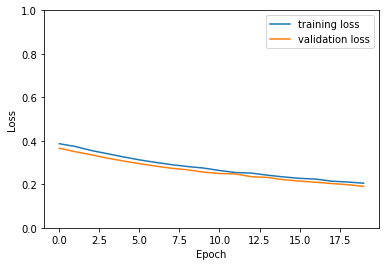

500/500 [==============================] - 0s 83us/sample - loss: 26753.3602 - R2: -158470.4844
Test Loss: 2.675e+04
Test R2: -1.585e+05


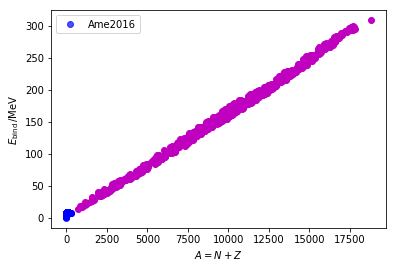

In [66]:
results=model.fit(xs_train,y_train,epochs=20, batch_size=16, validation_split=0.2,verbose=1)

history = results.history
plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0,1)
plt.show()

# test loss calculation

[test_loss,test_R2]=model.evaluate(xs_test, y_test, verbose=1)

print('Test Loss: {:.04}'.format(test_loss))
print('Test R2: {:.04}'.format(test_R2))

### Make some predictions

We can, in principle, hand the neural net a N,Z array, and predict binding energies

In [ ]:
print(model.predict([8,8]))